# Last year model

Prediction for the next day is taken as the flow from the day one year ago.

So if for the day 2017-03-03 we will use 2016-03-03 as a prediction

In [1]:
import datetime
import time
import calendar
import json
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Load project

In [2]:
project_folder = '../../datasets/thorium-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print(json.dumps(project, indent=4))
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
flow_rain = pd.concat([flow, rainfall], axis=1).dropna()
flow_rain = flow_rain['2015-06-02':'2017-11-09']
print(flow_rain.head())
print(flow_rain.tail())
flow = flow_rain['flow']
rainfall = flow_rain['rainfall']

{
    "end-date": "2017-12-31",
    "flows": [
        "flow1"
    ],
    "name": "thorium-medium",
    "rainfalls": [
        "rainfall1"
    ],
    "split-date": "2017-01-01",
    "start-date": "2015-06-02"
}
                           flow  rainfall
time                                     
2015-06-02 00:00:00  100.889999       0.0
2015-06-02 00:05:00   99.839996       0.0
2015-06-02 00:10:00   99.279999       0.0
2015-06-02 00:15:00   98.139999       0.0
2015-06-02 00:20:00   97.110001       0.0
                           flow  rainfall
time                                     
2017-11-09 23:35:00  111.739998       0.0
2017-11-09 23:40:00  110.949997       0.0
2017-11-09 23:45:00  110.519997       0.0
2017-11-09 23:50:00  109.190002       0.0
2017-11-09 23:55:00  107.089996       0.0


## Helper functions

Helper functions for building training and test sets and calculating score

In [53]:
class PredictionModel:
    """Mean model as a reference baseline"""
    
    def fit(self, flow, rain):
        self.mean = np.mean(flow.values)
        
    def predict(self, day, rain):
        return np.ones(288) * self.mean
    
    
def loss(y_hat, y):
    """
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    """
    return 100.0 * np.sum(np.abs((y-y_hat) / y)) / y.shape[0]


def split_data(flow, split_day):
    """Get all data up to given day"""
    end_day = split_day - pd.Timedelta('1 min')
    return flow[:end_day]


def evaluate_day(model, flow, rain, day):
    """Evaluate data for single day"""
    xs = split_data(flow, day)
    y = flow[day: day+pd.Timedelta('1439 min')]
    model.fit(xs, rain)
    y_hat = model.predict(day, rain)
    return loss(y_hat, y)


def evaluate_model(model, flow, rain, start_day):
    """
    Evaluate model on all days starting from split_day.
    Returns 90th percentile error as model score
    """
    last_day = flow.index[-1] - pd.Timedelta(1, 'D')
    pred_day = start_day
    costs = []
    while pred_day < last_day:
        cost = evaluate_day(model, flow, rain, pred_day)
        costs.append(cost)
        pred_day += pd.Timedelta(1, 'D')
    return np.percentile(costs, 95), costs


def plot_prediction(model, day, show_rain=True):
    rcParams['figure.figsize'] = 12, 8
    ts = pd.Timestamp(day)
    pred = model.predict(ts, rainfall)
    if show_rain:
        rcParams['figure.figsize'] = 12, 8
        fig = plt.figure()
        ax = plt.subplot(211)
        ax.plot(rainfall[ts: ts+pd.Timedelta('1439 min')].values, label='Rainfall')
        plt.title(day)
        ax = plt.subplot(212)
        ax.plot(pred, label='Prediction')
        ax.plot(flow[ts: ts+pd.Timedelta('1439 min')].values, label='Flow')
    else: 
        rcParams['figure.figsize'] = 12, 4
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.title(day)
        ax.plot(pred, label='Prediction')
        ax.plot(flow[ts: ts+pd.Timedelta('1439 min')].values, label='Flow')
    ax.legend()
    plt.show()


score, costs = evaluate_model(PredictionModel(), flow, rainfall, pd.Timestamp('2017-01-01'))
print('MeanModel score: {:.2f}% (expected: 22.69%)'.format(score))

MeanModel score: 22.69% (expected: 22.69%)


## Build model

In [65]:
class LastYearModel(PredictionModel):
    
    def fit(self, flow, rain):
        self.y = flow
        
    def predict(self, day, rain):
        pred_day = day-pd.Timedelta(days=366)
        return self.y[pred_day: pred_day + pd.Timedelta('1439 min')].values
    
    
last_year_model = LastYearModel()
score, costs = evaluate_model(last_year_model, flow, rainfall, pd.Timestamp('2017-01-01'))
print('LastYearModel score: {:.2f}%'.format(score))

LastYearModel score: 17.31%


## Explore results

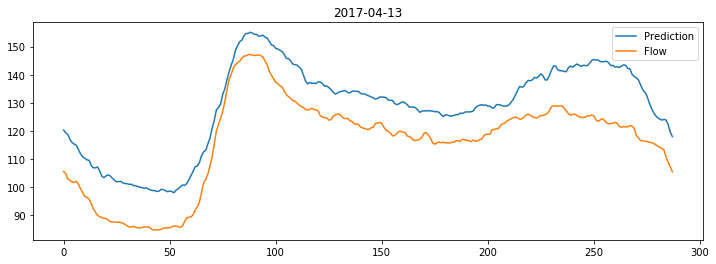

In [66]:
plot_prediction(last_year_model, '2017-04-13', show_rain=False)

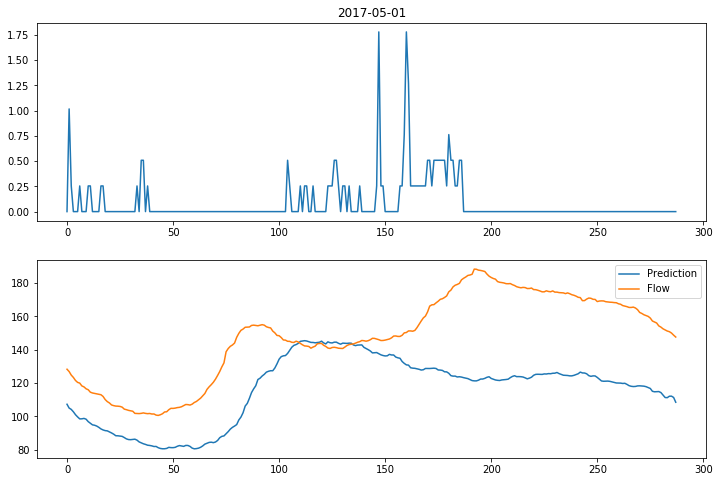

In [67]:
plot_prediction(last_year_model, '2017-05-01')